### CUNY Data 620 - Web Analytics, Summer 2020
**Group Homework Assignment 6**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

**Youtube Link:** https://www.youtube.com/watch?v=osAK2L9ir1Y

### Instructions

It can be useful to be able to classify new "test" documents using already classified "training" documents. A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam. Here is one example of such data: http://archive.ics.uci.edu/ml/datasets/Spambase 

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

### Methodology
For this project, we will train 5 classifers: an SVM, K-Nearest Neighbors, Naive Bayes, Decision Tree, and Random Forest. For each, we will fit the model to a training set and calculate the accuracy, precision, and recall on the test set. 

* **Accuracy:** The percent of emails properly classified. 
* **Precision - True Positive Rate**: The percent of emails classfied as spam that are actually spam. A precision of 100% means that all records classified as spam are spam. A low precision means that many of the classified spam emails are actually not spam. 
* **Recall**: The percent of spam emails that are properly classified. A recall of 100% means that all true spam emails are classified as spam. A low recall means that many of the spam emails are classified as not spam. 

Although we want to ensure that we are filtering out spam, we also want to do our best to send all actual emails to the inbox. (No one wants to miss an important email due to the spam filter!) Because of this, our final comparison will be based on **recall for class 0**, which measures the number of properly classified non-spam emails. The higher the recall, the more non-spam documents are classified as non-spam.

Additionally, for our 2 tree-based models, we will look at the feature importances to see the contributions of each feature in classifying the document. 

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import ensemble

### Data Exploration

Using the link mentioned above we will download 2 files i.e "spambase.data" and "spambase.names".<br> The spambase.data file contains various parameters for each file as well as a classificationof ham or spam (i.e 1 = spam, 0 = Not spam). The spambase.names file contains the descriptions of each of the features. We will extract these features from the file and apply them to the dataset to create models. 

In [2]:
# extract feature from spambase.names file.

# created an empty feature list
categories = []

# open file 
feature_file = open('data/spambase.names')
# remove '\n', split the text,  and match with word_freq|char_freq feature 
for line in feature_file:
    if not re.match(r'\|', line):
        line = line.rstrip()
        if re.search(r'(word_freq_|char_freq_|capital_run_length_).+', line):   
            words = line.split()
            first_word = words[0]
            categories.append(first_word[:-1])
#The list of features in the names file doesn't include the column definind spam/ham, so let's add one. 

categories.append('spam')
print('A sample of 5 features: \n',categories[:5])

A sample of 5 features: 
 ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our']


Let's now load the data from the data file and apply our 'categories' list as the column header. 

In [3]:
data=pd.read_csv('data/spambase.data', header=None)
data.columns = categories

#### Spam, Non-Spam Breakouts

Let's take a look at our dataset ot see how much spam and how much ham we have. 

In [4]:
# Count spam and non-spam
count_spam = len(data[data.spam == 1])
count_nonspam = len(data[data.spam == 0])

print("Spam: %d" %count_spam)
print("Non-spam: %d" %count_nonspam)

Spam: 1813
Non-spam: 2788


In [5]:
data.head(4)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1


Lets see what percentage of our data is spam/Not spam. 

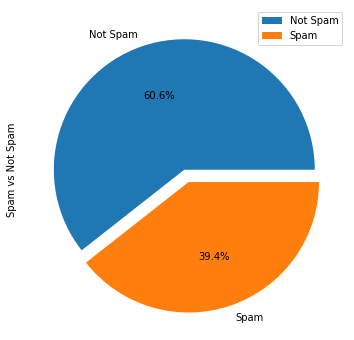

In [6]:
# pie plot of spam/not spam 

labels = ['Not Spam','Spam']
data['spam'].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', labels=labels)
plt.ylabel("Spam vs Not Spam")
plt.legend(["Not Spam", "Spam"])
plt.show()

#### Data splitting:

This table consists of 58 columns, we will divide the dataset into 2 parts i.e the train and the test set. Train data is 75% of data and test data is 25% of data. We will create two variables: the output will be the 'spam' column, the input will be everything else. We also want to ensure that we stratify the model so that we have a representative breakdown of Spam and Ham.

* Parameter test_size is given value 0.25. It means test set will be 25% of the whole dataset and training set will be 75%. 
* Parameter random_state is a pseudo-random number generator state used for random sampling.

In [7]:
X = data.values[:, 0:57]
Y = data.values[:, 57]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 4, stratify=Y)

#### Metric Calculations
We will define a function that returns a confusion matrix and classification report for our test sets.

In [8]:
# Determine Performance Metrics
def perf_metrics(y_test, prediction):
    cm = confusion_matrix(y_test, prediction)
    cr = classification_report(y_test,prediction, output_dict=True)
    print(cm)
    print(classification_report(y_test,prediction))
    return cm, cr

### Model 1: Support Vector Machine

We will fit our training data to a Support Vector Machine model, predict on the test set, and evalate the performance of the model in terms of (1) accuracy, (2) precision, and (3) recall. 

In [9]:
svm_model = svm.SVC()
svm_model.fit(X_train, Y_train)

# Prediction
svm_pred = svm_model.predict(X_test)

# find accuracy on the Test Set
print('The accuracy of the test set with an SVM model is: ', accuracy_score(Y_test, svm_pred))

The accuracy of the test set with an SVM model is:  0.7115551694178974


In [10]:
cmSvm, crSvm = perf_metrics(Y_test,svm_pred)

[[618  79]
 [253 201]]
              precision    recall  f1-score   support

         0.0       0.71      0.89      0.79       697
         1.0       0.72      0.44      0.55       454

    accuracy                           0.71      1151
   macro avg       0.71      0.66      0.67      1151
weighted avg       0.71      0.71      0.69      1151



* **Accuracy**: Overall, about 71% of the documents were classified properly. 
* **Precision**: The model performs similarly on non-spam (label = 0) and spam (label = 1) emails.
* **Recall**: The model is better at recognizing non-spam than it is at recognizing spam. 89% of non-spam records are properly identified, whereas only 44% of spam records are identified properly. This also means that around 11% of non-spam emails are being predicted as spam!

### Model 2: K Nearest Neighbors

When putting together a K-Nearest Neighbors model we wanted to ensure we were selecting the optimal number of neighbors for our dataset. To do so, we looped through a range of values and identified the number of neighbors that corresponded to the highest accuracy. 

In [11]:
n_neigh = range(1,21)
K_N_acc = []
for n in n_neigh:
    k_neigh = KNeighborsClassifier(n_neighbors = n)
    k_neigh.fit(X_train,Y_train)
    k_neigh_pred = k_neigh.predict(X_test)
    K_N_acc.append(accuracy_score(Y_test, k_neigh_pred))
K_N = {"n_neighbors":n_neigh,'Accuracy':K_N_acc}
K_N = pd.DataFrame(K_N)
K_N.head().style.hide_index()

n_neighbors,Accuracy
1,0.806255
2,0.786273
3,0.807993
4,0.790617
5,0.805387


By plotting these results we can find the best number of neightbors to use. From this set of data it seems that the best number to use for our data is 3. It's interesting to note that the results for each value follows the general rule that even numbers of pairs tend to be less accurate for classifications into 2 groups. After 9 nighbors we see a significant dropoff in marginal accuracy. 

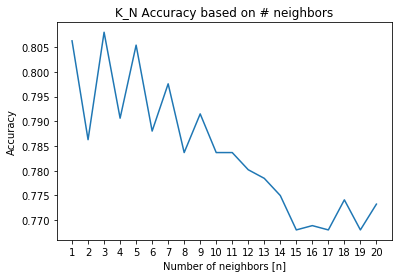

In [12]:
plt.plot(n_neigh,K_N['Accuracy'])
plt.title('K_N Accuracy based on # neighbors')
plt.xlabel('Number of neighbors [n]')
plt.ylabel('Accuracy')
plt.xticks(n_neigh)
plt.show()

Now that we have identified the optimal value for n_neighbors, let's see what our model looks like when compared to the test values. 

In [13]:
K_N_3 = KNeighborsClassifier(n_neighbors = 3)
K_N_3.fit(X_train,Y_train)
K_N_3_pred = K_N_3.predict(X_test)

cmKnn, crKnn = perf_metrics(Y_test,K_N_3_pred)

[[598  99]
 [122 332]]
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       697
         1.0       0.77      0.73      0.75       454

    accuracy                           0.81      1151
   macro avg       0.80      0.79      0.80      1151
weighted avg       0.81      0.81      0.81      1151



* **Accuracy**: Accuracy has increased from 71% using an SVM to 81% using a KNN classifier. 
* **Precision**: The precision has increased, which means that more of the emails classified as spam are actually spam. 
* **Recall**: However, our recall has decreased. About 14% of the non-spam emails are classified as spam. 

### Model 3: Naive Bayes Classifier

The next model we decided to try was Naive Bayes. Naive Bayes works under the assumption of conditional probability, that given our already classified training set as spam or ham, we can ask, "What is the probability that the latest email is ham or spam *given* that it contains the following features?".

The algorithm will classify each email by looking at it's features individually, calculating the probability that the e-mail contains this feature, and then repeats this process on the next feature, and so on, eventually multiplying the probabilities together of each feature to determine which probability (more likely spam or ham), is greater.  

With our features already extracted for each e-mail, and after [doing a bit of research](https://towardsdatascience.com/comparing-a-variety-of-naive-bayes-classification-algorithms-fc5fa298379e) on which type of Naive Bayes classifier to use, we decided to go with a Bernoulli Naive Bayes algorithm:

In [14]:
BernNB = BernoulliNB(binarize=True)
BernNB.fit(X_train, Y_train)
nbpred = BernNB.predict(X_test)
cmNb, crNb = perf_metrics(Y_test, nbpred)

[[624  73]
 [ 87 367]]
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       697
         1.0       0.83      0.81      0.82       454

    accuracy                           0.86      1151
   macro avg       0.86      0.85      0.85      1151
weighted avg       0.86      0.86      0.86      1151



We can see a bit of an improvement over our previous SVM and KNN algorithms:

* **Accuracy**: Accuracy has further increased to about 85%. 
* **Precision**: The precision has also increased, which means that more of the emails classified as spam are actually spam. 
* **Recall**: Our recall has also increased. Now only about 10% of non-spam emails are being classified as spam.

### Model 4: Decision Tree Classifier

Our next approach was to use a decision tree classifier model on our dataset. One of the main parameters for a Random Forest model is the maximum depth of the splits. As with the K-Nearest-Neighbors model we will loop through various values to determine the best one. 

In [15]:
depth = range(1,21)
Tree_acc = []
for d in depth:
    Tree = tree.DecisionTreeClassifier(max_depth = d)
    Tree.fit(X_train,Y_train)
    Tree_pred = Tree.predict(X_test)
    Tree_acc.append(accuracy_score(Y_test, Tree_pred))
    
TREE = {"Max Depth":depth,'Accuracy':Tree_acc}
TREE = pd.DataFrame(TREE)
TREE.head().style.hide_index()

Max Depth,Accuracy
1,0.779322
2,0.834057
3,0.880973
4,0.889661
5,0.895743


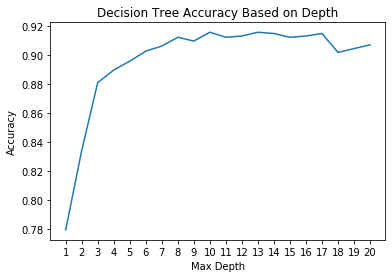

In [16]:
plt.plot(depth,TREE['Accuracy'])
plt.title('Decision Tree Accuracy Based on Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth)
plt.show()

In [17]:
best_depth_idx = TREE['Accuracy'].idxmax()
best_acc = max(TREE['Accuracy'])
best_dep = int(TREE.iloc[best_depth_idx]['Max Depth'])
print(f"The best accuracy of {best_acc:.2%} comes from a max depth of {best_dep}")

The best accuracy of 91.57% comes from a max depth of 10


In [18]:
Best_Tree = tree.DecisionTreeClassifier(max_depth = best_dep)
Best_Tree.fit(X_train,Y_train)
Best_Tree_pred = Best_Tree.predict(X_test)

cmTree, crTree = perf_metrics(Y_test,Best_Tree_pred)

[[658  39]
 [ 65 389]]
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       697
         1.0       0.91      0.86      0.88       454

    accuracy                           0.91      1151
   macro avg       0.91      0.90      0.90      1151
weighted avg       0.91      0.91      0.91      1151



Now this looks a lot better! 

* **Accuracy**: Accuracy has further increased to 91%! 
* **Precision**: The precision has also increased, which means that more of the emails classified as spam are actually spam. 
* **Recall**: Our recall has also increased. Now only 5% of non-spam emails are being classified as spam!

### Model 5: Random Forest Classifier

Our last model will be a **Random Forest Classifier**. We'll do things a little differently:
* First, we'll define a parameter grid to search over.
* Next, we'll use 5-fold **stratified** cross-validation to ensure that a representative sample of spam and non-spam documents are included in each fold. 
* Then, we'll search the parameter grid to identify the best values for the max_depth, number of estimators, and criterion. 

Once we've identified the best model, we can predict on our test set and identify the final metrics. 

In [19]:
%%capture
# Create the parameter grid
param_grid = {
    'max_depth': list(range(0,25,5)),
    'n_estimators': list(range(0,200,50)),
    'criterion': ['gini', 'entropy']}

# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid,
                           cv = kfold, 
                           n_jobs = -1, 
                           verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train,Y_train)

In [20]:
#################### Final Model
best_grid = grid_search.best_estimator_
best_params = grid_search.best_params_
best_index = grid_search.best_index_
best_score = grid_search.best_score_

print(f"The best accuracy of {best_score:.2%} comes from the following parameters: {best_params}")

The best accuracy of 95.10% comes from the following parameters: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}


In [21]:
rf_pred = best_grid.predict(X_test)

cmRf, crRf = perf_metrics(Y_test, rf_pred)

[[675  22]
 [ 40 414]]
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       697
         1.0       0.95      0.91      0.93       454

    accuracy                           0.95      1151
   macro avg       0.95      0.94      0.94      1151
weighted avg       0.95      0.95      0.95      1151



Our last model is the best out of all 5: 

* **Accuracy**: Accuracy has increased once again to 95%.
* **Precision**: Precision has also increased. 
* **Recall**: Recall has increased to 97% on the 0 class, which means that only 3% of non-spam emails are being classified as spam. 

### Feature Importances

#### Top 5 features

We can identify the most important features from our tree-based models.

In [22]:
# Random Forest importances
treeImp = list(Best_Tree.feature_importances_)
treeImpFeatureImps = [(feature, round(importance, 3)) for feature, importance in zip(categories, treeImp)]
treeImpFeatureImps = sorted(treeImpFeatureImps, key = lambda x: x[1], reverse = True)
print('Decision Tree Model - Top 5 features')
treeImpFeatureImps[0:5]

Decision Tree Model - Top 5 features


[('char_freq_!', 0.404),
 ('capital_run_length_longest', 0.125),
 ('word_freq_remove', 0.121),
 ('word_freq_free', 0.063),
 ('word_freq_hp', 0.049)]

In [23]:
# Random Forest importances
rfImp = list(best_grid.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(categories, rfImp)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print('Random Forest Model - Top 5 features')
feature_importances[0:5]

Random Forest Model - Top 5 features


[('char_freq_!', 0.106),
 ('char_freq_$', 0.084),
 ('word_freq_remove', 0.07),
 ('word_freq_free', 0.07),
 ('capital_run_length_average', 0.064)]

From this, we can see: 
* 4 of the 5 top features are in both models.
* **char_freq_!** is the top feature in both models, however, it is weighted much higher in the decision tree model than the random forest model. 
* **char_freq_?** appears as the second highest feature in the random forest model, but doesn't appear at all in the decision tree model. 

Although both tree models perform very well, the high contribution of the **char_freq_!** feature in the Decision Tree model might be the reason the Random Forest model performs better.

#### Least Important Features

We can also identify the least important features. We'll count how many features have an importance of 0:

In [24]:
print('Number of features with 0 importance in Decision Tree Model: ',
      len([(feat,imp) for feat,imp in treeImpFeatureImps if imp == 0.0]))

print('Number of features with 0 importance in Random Forest Model: ',
      len([(feat,imp) for feat,imp in feature_importances if imp == 0.0]))

Number of features with 0 importance in Decision Tree Model:  20
Number of features with 0 importance in Random Forest Model:  4


This is interesting and tells us that many of the features in the **Decision Tree** model were not used in predicting the classification of spam/not spam. 

#### Plotting Features
We can also plot the feature importances to visualize the contributions of each element. 

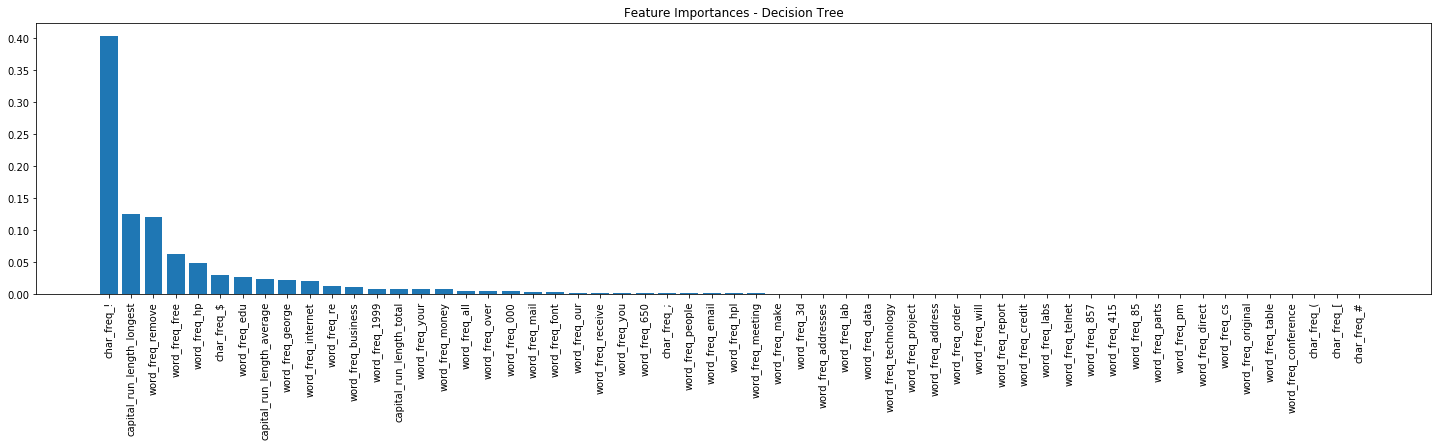

In [25]:
# plot feature importance
plt.figure(figsize=(25, 5))
plt.bar(*zip(*treeImpFeatureImps), orientation = 'vertical')
plt.xticks(rotation='vertical')
plt.title("Feature Importances - Decision Tree")
plt.show()

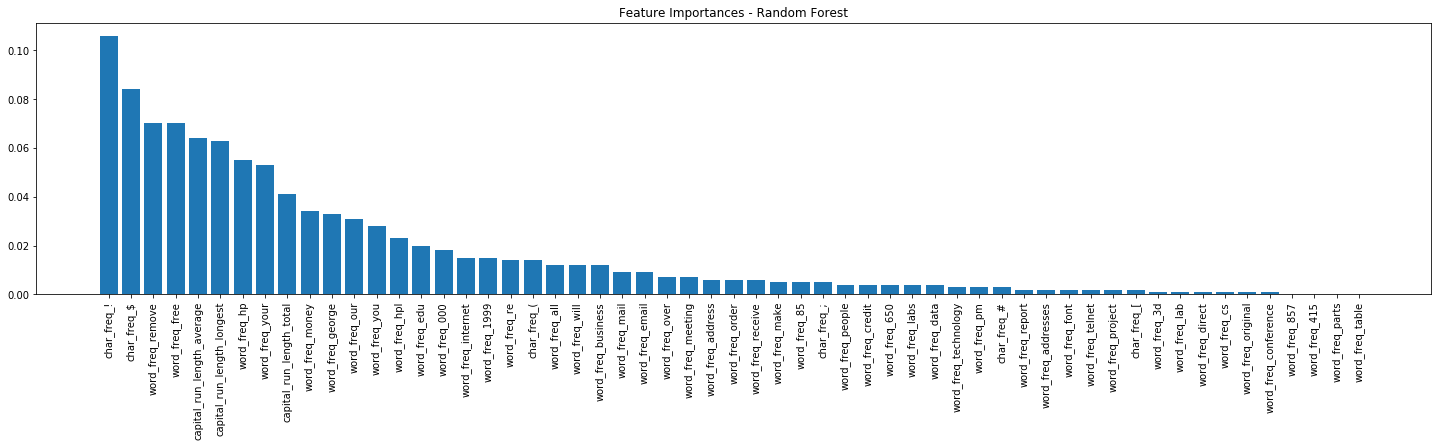

In [26]:
# plot feature importance
plt.figure(figsize=(25, 5))
plt.bar(*zip(*feature_importances), orientation = 'vertical')
plt.xticks(rotation='vertical')
plt.title("Feature Importances - Random Forest")
plt.show()

This visual shows us that there is a greater balance of feature importances in the Random Forest Model. In other words, more features are contributing to the final prediction.

### Model Evaluation
Finally, we can look at all of our model metrics side-by-side: 

In [27]:
svmMetrics = ('SVM', crSvm['0.0']['recall'], crSvm['accuracy'], crSvm['macro avg']['precision'], crSvm['macro avg']['recall'])
knnMetrics = ('KNN', crKnn['0.0']['recall'], crKnn['accuracy'], crKnn['macro avg']['precision'], crKnn['macro avg']['recall'])
nbMetrics = ('NB', crNb['0.0']['recall'], crNb['accuracy'], crNb['macro avg']['precision'], crNb['macro avg']['recall'])
treeMetrics = ('TREE', crTree['0.0']['recall'], crTree['accuracy'], crTree['macro avg']['precision'], crTree['macro avg']['recall'])
rfMetrics = ('RF', crRf['0.0']['recall'], crRf['accuracy'], crRf['macro avg']['precision'], crRf['macro avg']['recall'])

metricCompare = pd.DataFrame([svmMetrics, knnMetrics, nbMetrics, treeMetrics, rfMetrics], 
             columns = ['MODEL', 'RECALL_0CLASS', 'ACCURACY', 'PRECISION_OVERALL', 'RECALL_OVERALL'])

metricCompare

,MODEL,RECALL_0CLASS,ACCURACY,PRECISION_OVERALL,RECALL_OVERALL
0,SVM,0.886657,0.711555,0.713693,0.664694
1,KNN,0.857963,0.807993,0.800429,0.794620
2,NB,0.895265,0.860990,0.855864,0.851818
3,TREE,0.944046,0.909644,0.909488,0.900437
4,RF,0.968436,0.946134,0.946799,0.940165


From this, we can see that the fitted random forest model performs the best across all metrics. Although we wanted to optimize for 0 class recall, we have a nice balance between all of our metrics. In other words, not only are we classifying non-spam emails properly, but we're also classifying spam emails well (precision)!

### Discussion

This analysis shows us that a **Random Forest Model** outperforms the SVM, Naive Bayes, KNN, and Decision Tree Models when classifying emails as spam/not-spam. We have obtained a final accuracy of just under 95%, a 0-Class recall value of almost 97%, and an overall precision of ~95%. This means that 95% of documents were properly classified, only ~3% of the non-spam emails would be sent to the junk folder, and 95% of the documents classified as spam are actually spam. 

### Reference


https://towardsdatascience.com/random-forest-in-python-24d0893d51c0